# Курс "Название"

---
# Семинар 6. Классификация сигналов в Keras.

<html>
  <head>
    <meta charset='utf-8'>
  </head>
  <body>
    <ul>
      <li><strong>1. Цифровая обработка сигналов (ЦОС)</strong>
      <ul>
        <li>1.1 Случайные сигналы</li>
      </ul>
      <ul>
        <li>1.2 Детерминированные сигналы</li>
      </ul>
      <ul>
        <li>1.3 Модуляция</li>
              <ul>
        <li>1.3.1 Амплитудная модуляция</li>   
      </ul>
            <ul>
        <li>1.3.2 Угловая модуляция</li>     
      </ul>
            <ul>
        <li>1.3.3 Частотная модуляция</li>   
      </ul>
            <ul>
        <li>1.3.4 Линейно-частотная модуляция</li>    
      </ul>
      </ul>
    </ul>
    <ul>
      <li><strong>2. Создание нейронной сети</strong>
      <ul>
        <li>2.1 Введение в Keras</li>
      </ul>
      <ul>
        <li>2.2 Подготовка базы данных</li>
      </ul>
    </ul>
    </ul>
  </body>
</html>

**Подгрузим необходимые библиотеки в проект**

In [ ]:
import numpy as np
import random
from scipy.fftpack import fft, rfft, fftshift
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

import seaborn as sns
sns.set_style('darkgrid')

# **2. Создание нейронной сети**

## Введение в Keras

Русскоязычная версия документации библиотеки Keras [здесь](https://ru-keras.com/home/)

## Подготовка базы данных

В данном семинаре будет решаться задача классификации. В качестве базы данных будем использовать модулированные сигналы. 

Будем классифицировать сигналы по следующим классам:

класс 1 - амплитудная модуляция

класс 2 - частотная модуляция 

класс 3 - линечно-частотная модуляция

**Генератор выборки**

Для начала требуется сгенерировать выборку на которой будем обучать нашу нейронную сеть. 

**Обучающая выборка (training set)** – набор данных, который
используется для обучения сети. Точность на ней может достигать
100%.

**Проверочная (валидационная) выборка (validation set)** – набор
данных, который используется в процессе обучения для оценки
качества обучения. Как правило, точность ниже, чем на обучающей
выборке. Ее часто путают с тестовой выборкой. Обычно создается
выделением части обучающей выборки для проверки работы модели.

**Тестовая выборка (test set)** – набор данных, который используется
для оценки качества работы сети после завершения обучения.
Используется для контрольной финальной проверки.

In [ ]:
def sample_signal_am(amp, km, fc, fs, period, noise):
    """
    Генерирование Амплитудно модулированного (АМ) сигнала

    Параметры сигнала:
    ----------
    amp : float
        Амплитуда сигнала
    km : float
    Коэффициент модуляции 0 <= km < 1
    fc : float
        Несущая частота
    fs : float
        Частота информационного сигнала сигнала
    period : integer
        Количество точек для сигнала (совпадает с периодом)
    noise: float
        СКО шума
    """
    tt = 2.0 * np.pi * np.linspace(0, 1, period)
    res = amp * (1 + km * np.cos(fs * tt)) * np.cos(fc * tt)
    res += np.random.normal(0, noise, period)
    return res

def sample_signal_fm(amp, kd, fc, fs, period, noise):
    """
    Создание Частотно модулированного (ЧМ) сигнала

    Параметры
    ----------
    amp : float
        Амплитуда сигнала
    kd : float
        Девиация частоты, kd < период/4,
        e.g. fc = 0, fs = 1, kd = 16
    fc : float
        Несущая частот
    fs : float
        Частота модулирующего (информационного) сигнала
    period : integer
        Количество точек для сигнала (совпадает с периодом)
    noise: float
        СКО шума
    """
    tt = 2.0 * np.pi * np.linspace(0, 1, period)
    res = amp * np.cos(fc * tt + kd/fs * np.sin(fs * tt))
    res += np.random.normal(0, noise, period)
    return res

def sample_signal_chirp(amp, freq, beta, period, noise):
    """
    Создание Линейно частотной модуляции (ЛЧМ)

    Параметры
    ----------
    amp : float
        Амплитуда сигнала
    beta : float
        Коэффициент ЛЧМ-модуляции: beta < N комплексное, beta < 0.5N действительное
    freq : float or int
        Начальное значение частоты
    period : integer
        Количество точек для сигнала (совпадает с периодом)
    noise: float
        СКО шума   
    """
    t = np.linspace(0, 1, period)
    tt = np.pi * (freq * t + beta * t ** 2)   
    res = amp * np.cos(tt)
    res += np.random.normal(0, noise, period)       
    return res

def create_samples(samples, period, noise):
  """
  Генерирование выборки сигналов
  АМ-сигнала - class 0
  ЧМ-сигнала - class 1
  ЛЧМ-сигнала (простого) - class 2

  Параметры
  ----------
  samples : integer
      Размер выборки
  period : integer
      Количество точек для сигнала (совпадает с периодом)
  noise: float
      СКО шума   
  """    

  sample_am = np.zeros((samples, period))
  sample_fm = np.zeros((samples, period))
  sample_chirp = np.zeros((samples, period))

  sft_am = np.zeros((samples, period))
  sft_fm = np.zeros((samples, period))
  sft_chirp = np.zeros((samples, period))

  sample_class = np.zeros((3*samples))
  sample_class[samples:samples*2] += 1
  sample_class[2*samples:] += 2

  for i in range(samples):

    # параметры подобраны случайно
    amp = 10 # отношение сигнал-шум примерно 30 дБ
    fc = round(random.uniform(50, 75), 2)
    fs = round(random.uniform(5, 25), 2)
    km = round(random.uniform(0.3, 0.8), 2)
    kd = random.randint(20, 75)
    f0 = round(random.randint(15, 55), 2)
    beta = round(random.uniform(25, 100), 2)
    is_complex = random.random()

    sample_am[i] = sample_signal_am(amp, km, fc, fs, period, noise)
    sample_fm[i] = sample_signal_fm(amp, kd, fc, fs, period, noise)
    sample_chirp[i] = sample_signal_chirp(amp, f0, beta, period, noise)

    # сразу нормализуем спектр - поделим на max

    sft_am[i] = np.abs(fft(sample_am[i]))
    sft_fm[i] = np.abs(fft(sample_fm[i]))
    sft_chirp[i] = np.abs(fft(sample_chirp[i]))

    sft_am[i] = sft_am[i] / max(sft_am[i])
    sft_fm[i] = sft_fm[i] / max(sft_fm[i])
    sft_chirp[i] = sft_chirp[i] / max(sft_chirp[i])
  
  sample = np.concatenate((sample_am, sample_fm, sample_chirp), axis=0)
  sft_sample = np.concatenate((sft_am, sft_fm, sft_chirp), axis=0)

  # перед формированием выборки требуется перемешать данные
  randomize = np.arange(len(sample))
  np.random.shuffle(randomize)
  sample_x = sample[randomize]
  sample_y = sft_sample[randomize]
  sample_z = sample_class[randomize]

  return sample_x, sample_y, sample_z.astype('int')

**Формирование выборок**

In [ ]:
# тренировочная выборка
train_x, train_y,  train_z = create_samples(samples=1000, period=2024, noise=0.1)

# проверочная выборка
val_x, val_y, val_z = create_samples(samples=300, period=2024, noise=0.1)

# # тестовая выборка
test_x, test_y, test_z = create_samples(samples=100, period=2024, noise=0.1)

**Отрисовка выборок**

In [ ]:
def plot_samples(sample, sft_sample, sample_class):
  n = 20
  for i in range(n):
    index = np.random.randint(0, sample.shape[0])
    plt.figure(figsize=(10, 5), dpi=120)
    plt.subplot(2, 2, 1)
    plt.title(f'class {sample_class[index]}')
    plt.plot(sample[index], color=f'C{sample_class[index]}')
    plt.xlim([0, sample.shape[1]-1])
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(sft_sample[index], color=f'C{sample_class[index]}')
    plt.xlim([0, sample.shape[1]/2-1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

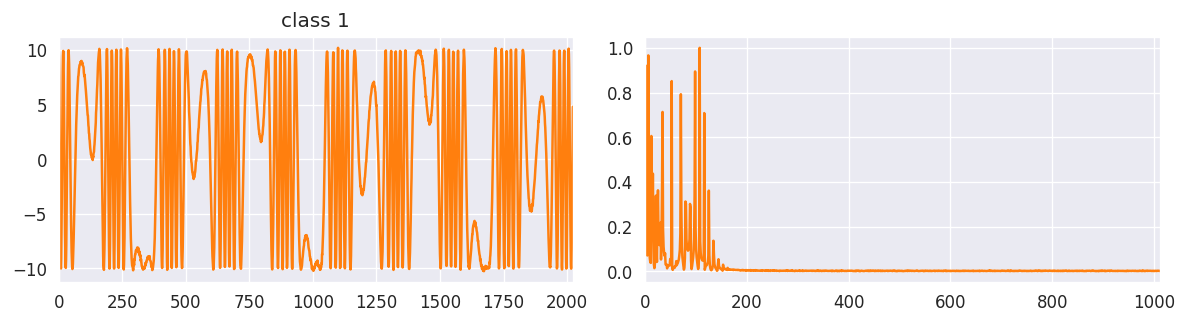

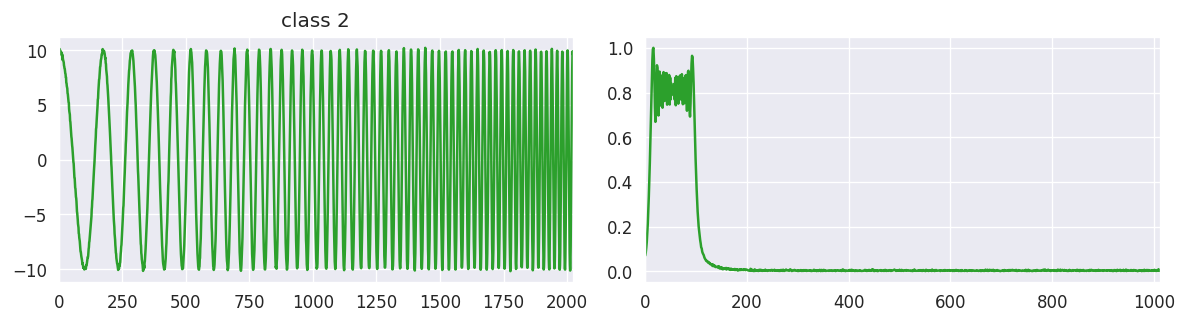

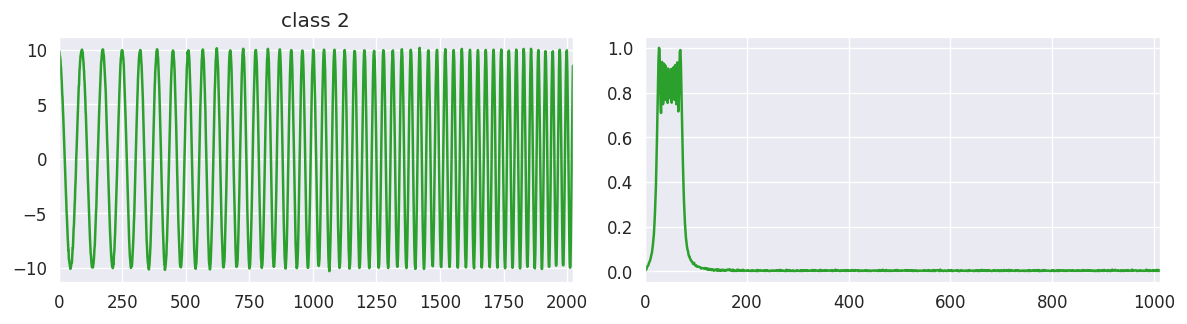

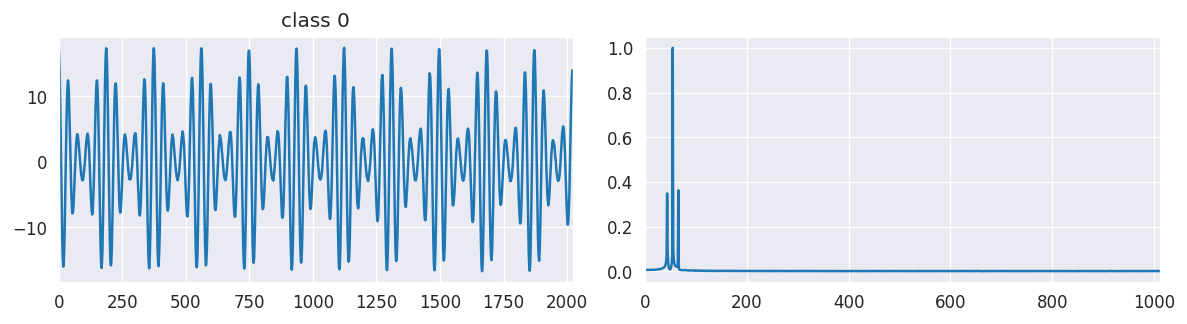

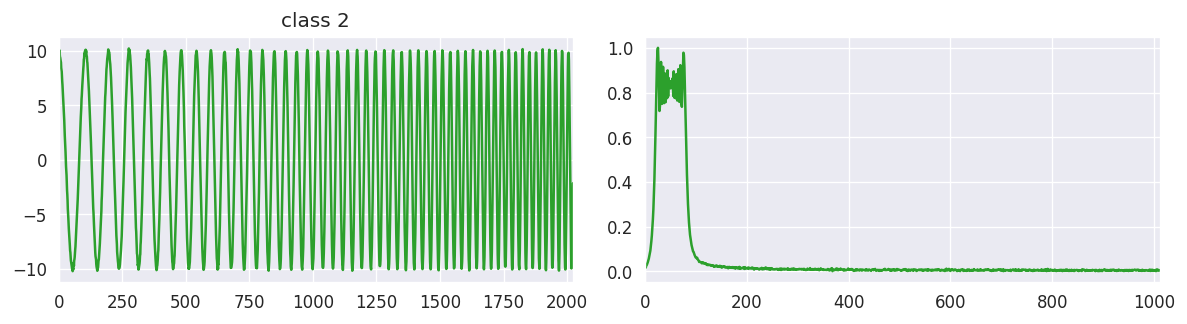

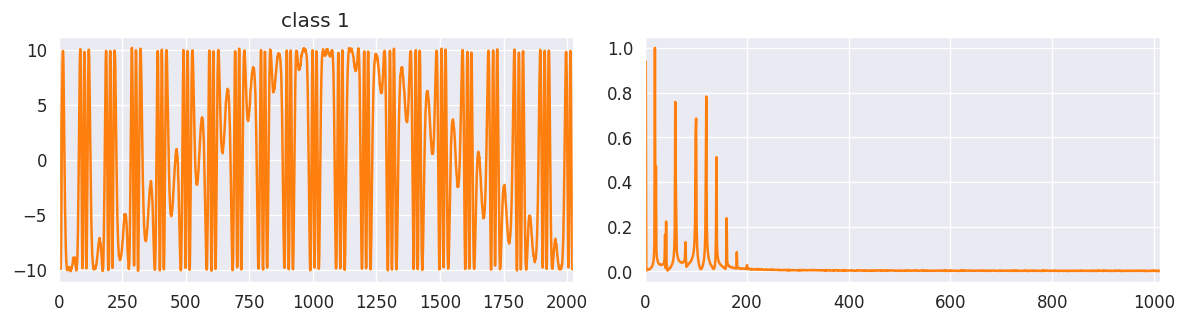

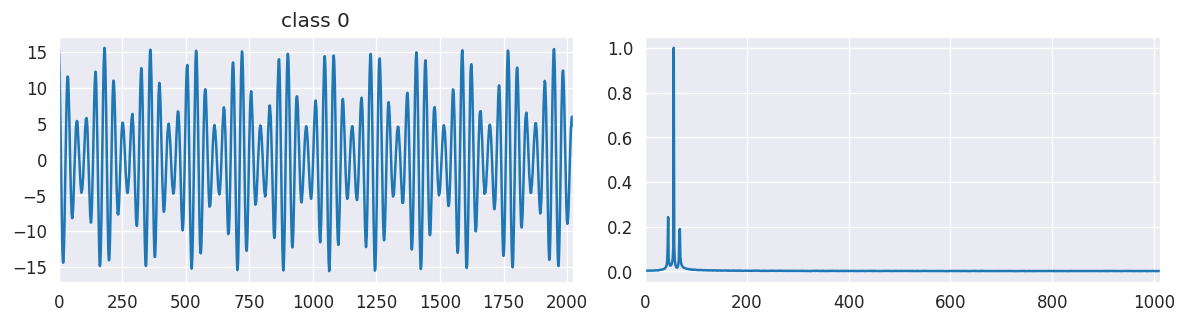

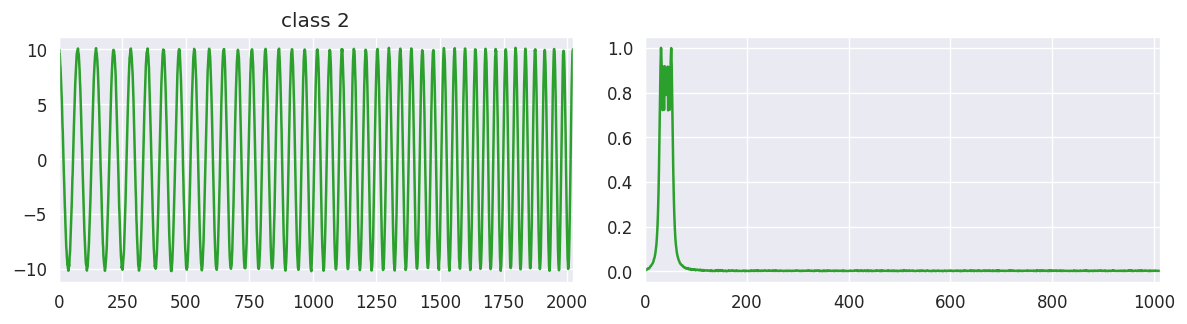

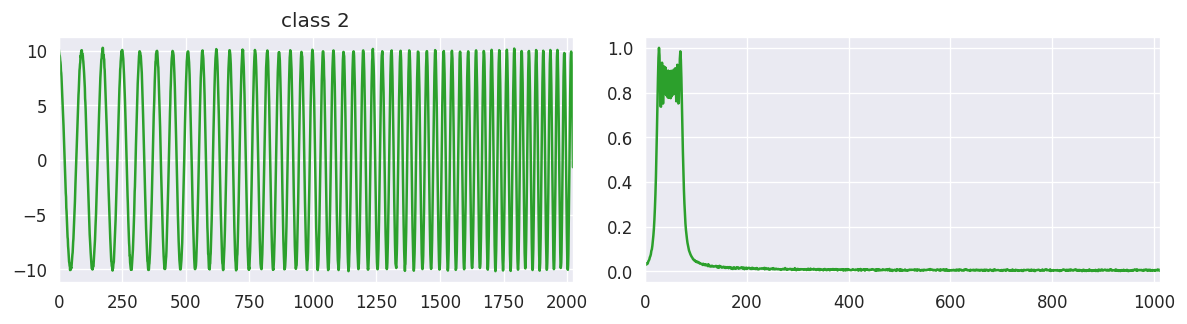

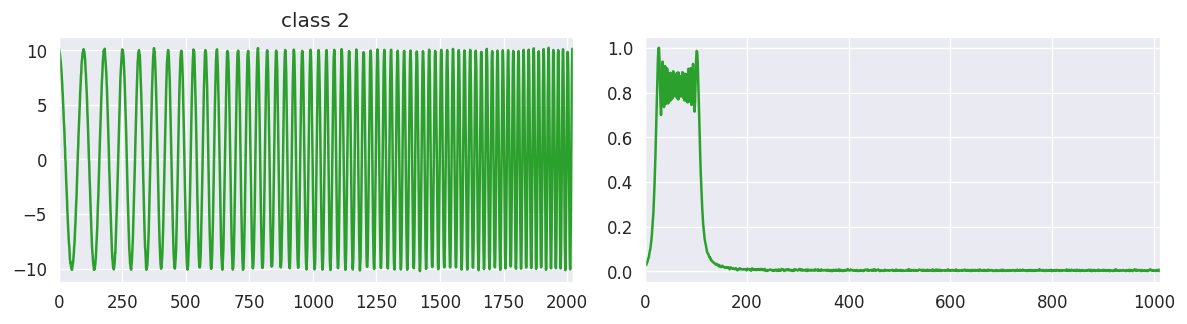

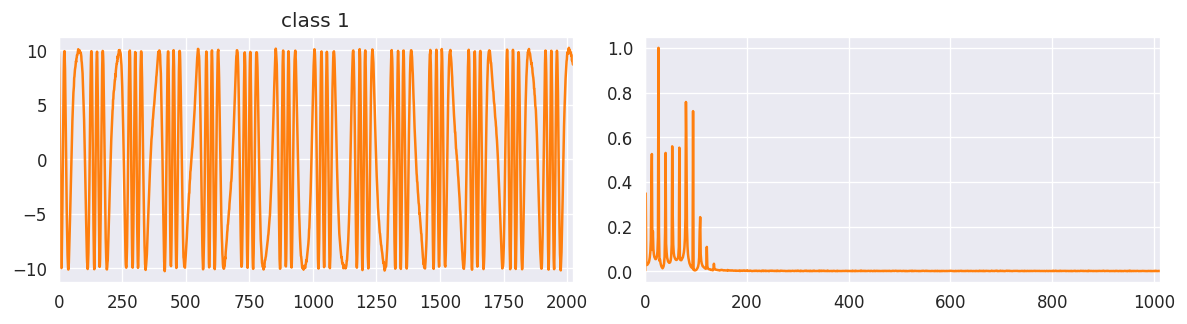

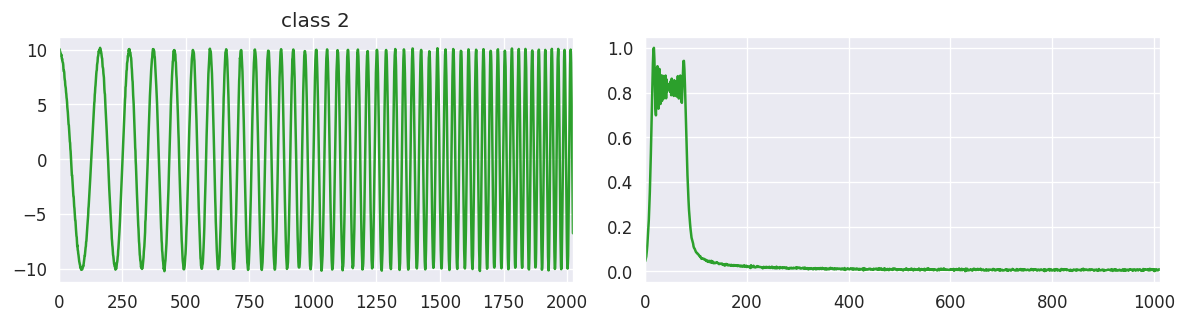

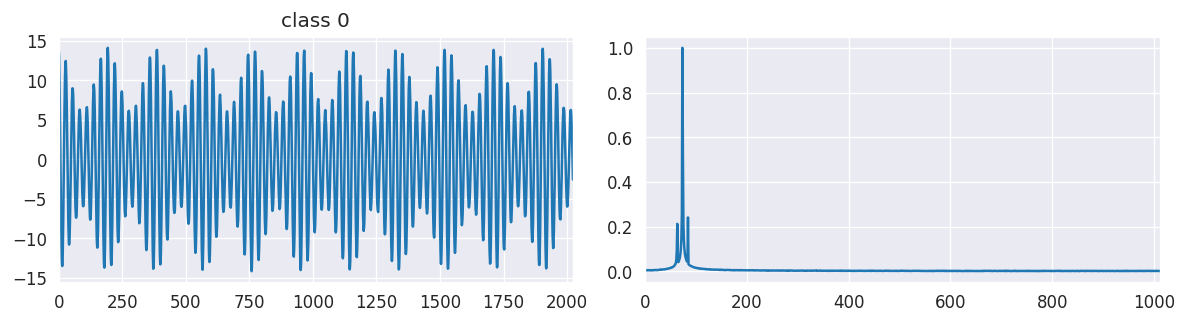

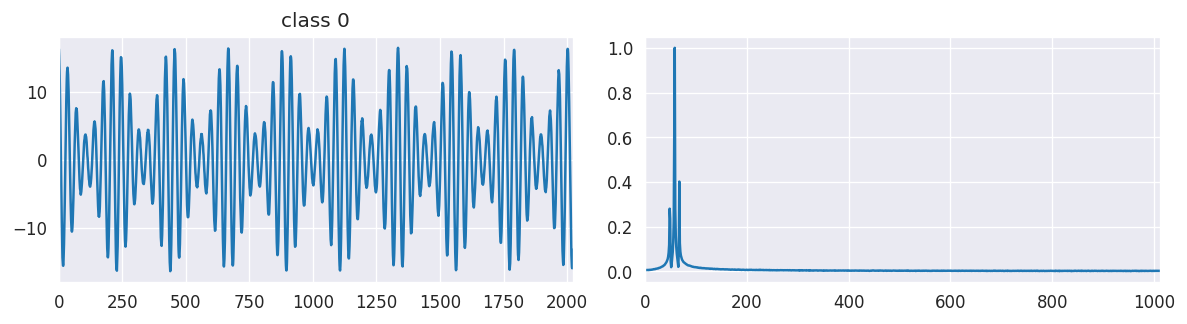

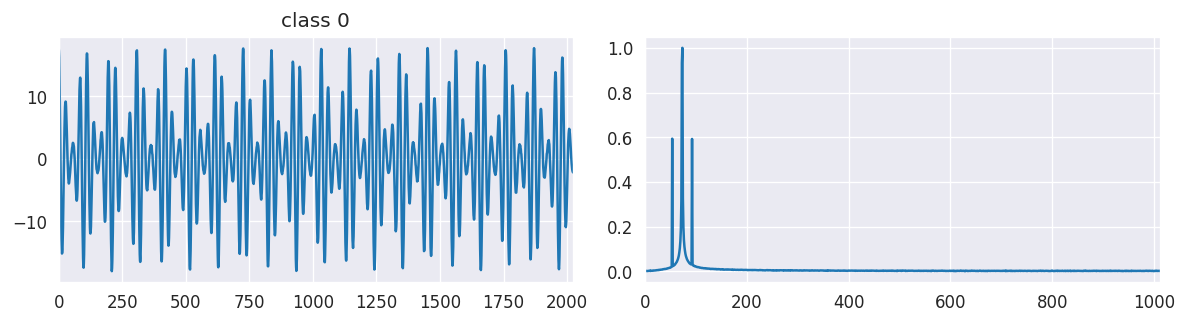

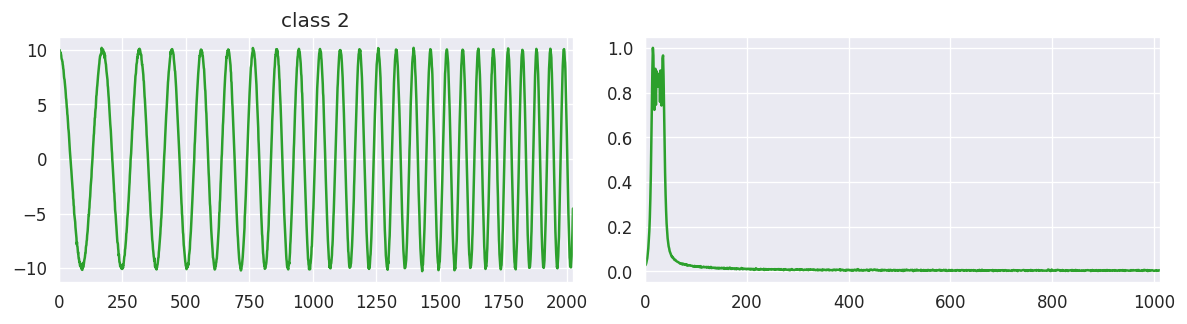

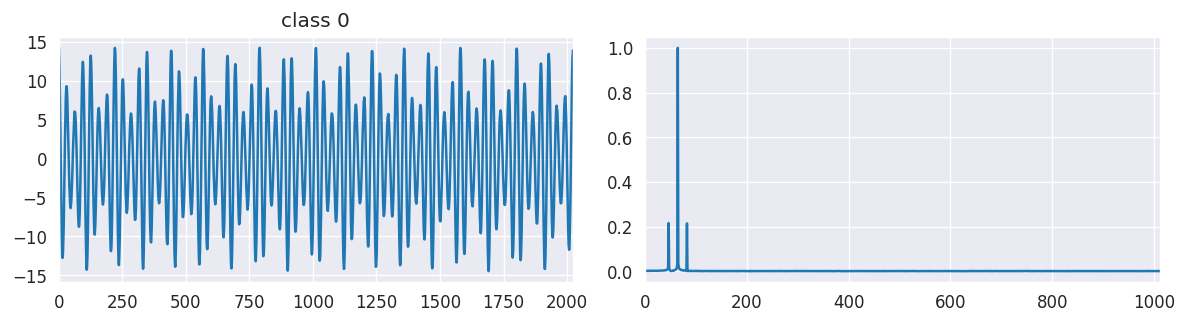

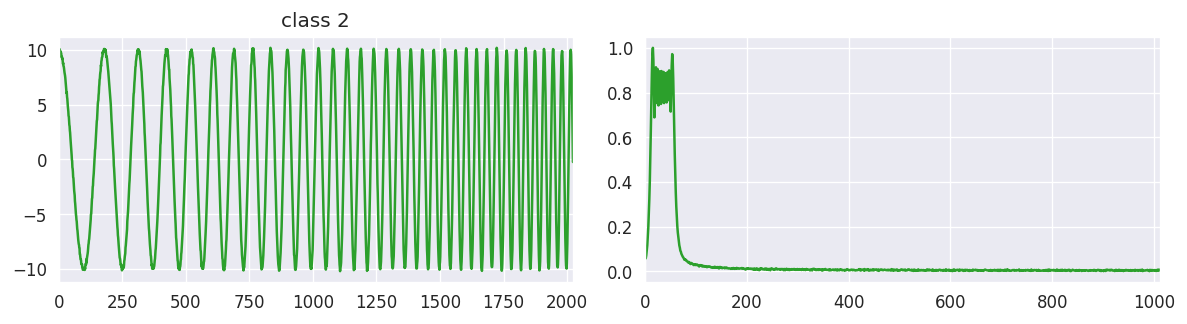

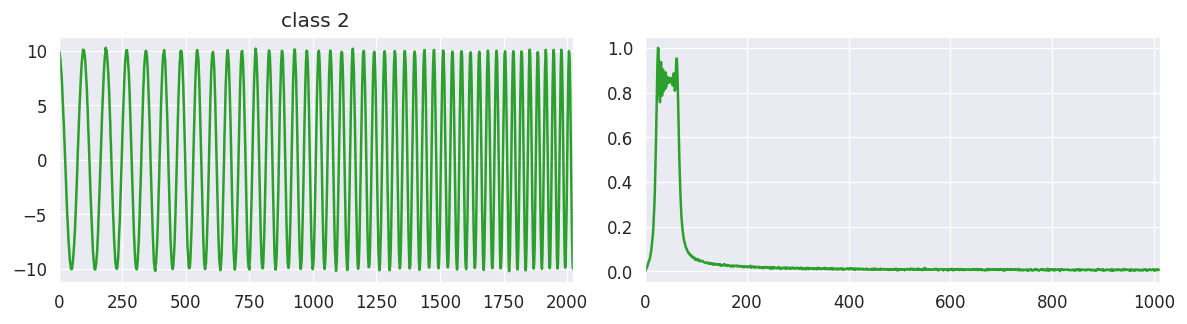

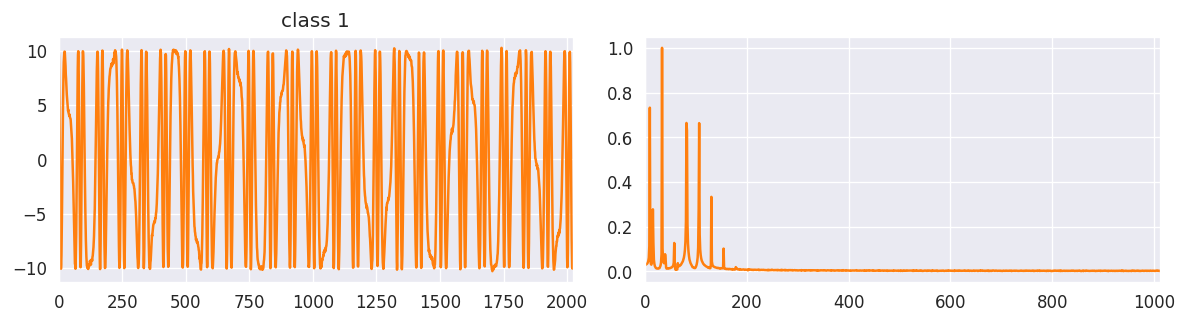

In [ ]:
plot_samples(train_x, train_y, train_z)

**Нормализация данных**

Нейронные сети показывают значительно лучшие результаты с данными, которые каким-либо образом нормализованы. 

**Методы нормализации данных.**

1. Нормальное распределение, также называемое Гауссовским распределением - это распределение вероятностей, которое в одномерном случае задается функцией плотности вероятности, совпадающей с функцией Гаусса.

2. MinMax распределение - линейное преобразование данных в диапазоне [0...1], где минимальное и максимальное масштабируемое значение равно 0 и 1 соответственно.

In [ ]:
# масштабируем данные - реализация (последовательность)
xScaler = StandardScaler()
xScaler.fit(train_x)
xTrain = xScaler.transform(train_x)
xVal = xScaler.transform(val_x)
xTest = xScaler.transform(test_x)

yTrain = train_y
yVal = val_y
yTest = test_y

# масштабируем данные - спектр
# yScaler = MaxAbsScaler()
# yScaler.fit(train_y)
# yTrain = yScaler.transform(train_y)
# yVal = yScaler.transform(val_y)
# yTest = yScaler.transform(test_y)

In [ ]:
# разбиение на категории
zTrain = utils.to_categorical(train_z).astype('int')
zVal = utils.to_categorical(val_z).astype('int')
zTest = utils.to_categorical(test_z).astype('int')

**Создание нейронной сети**

[Первые шаги в Keras](https://ru-keras.com/home/#P1_4)

Библиотека Keras предоставляет два способа создания модели нейронной сети: модель прямого распространения (Sequential) и функциональное программирование (Functional API). 

[Sequential](https://ru-keras.com/sequential/) - это модель в которой слои располагаются последовательно один за другим, подобно цепочке блоков. 

[Functional API](https://ru-keras.com/functional-api/) - модели определяются путем создания слоев и их непосредственного соединения друг с другом, а затем определения модели, которая задает слои, выступающие в качетсве входных и выходных данных.

У нейронной сети есть 2 типа параметров. Изменяемые в процессе обучения и неизменяемые "Гиперпараметры модели"

**Параметры модели** (на эти параметры может влиять сама модель):


*   изменяются в процессе обучения
*   для нейронной сети - веса входов в нейроны

**Гиперпараметры модели**


*   не меняются сетью в процессе обучения
*   влияют на конфигурацию модели и методы обучения
*   для нейронной сети - количество слоев, количество нейронов на слое, регуляризация, скорость обучения, размер мини-выборки

Гиперпараметры изменяются перед запуском обучения. Для изменения количества слоев и нейронов в слое нужно пересоздавать модель, т.е. веса модели обнулятся. Скорость обучения и размер выборки можно менять перед очередным этапом обучения без сброса весов. А скорость обучения можно менять в процессе обучения.

Процесс создания нейронной сети при наличии подготовленных данных сводится к следующему алгоритму. Установка гиперпараметров -> обучение сети на обучающей выборке -> проверка работы на валидационной выборке. И так по кругу, до достижения необходимых показателей. После этого нужна проверка на тестовой выборке для подтверждения результатов.










**[Слои](https://ru-keras.com/)**

Знакомство с Keras начнем со слоев Dense -  полносвязный слой. Это слой, все нейроны которого связаны с нейронами предыдущего слоя (или со всеми входными параметрами, если слой Dense является первым слоем модели.

**Весовые коэффициенты модели**

Весовые коэффициенты модели или просто веса модели - основные числовые характеристики нейронной сети, которые изменяются в процессе обучения модели для достижения оптимального результата.

При добавлении очередного слоя в модель методом .add() веса этого слоя инициализируются случайными сгенерированными значениями. Простыми словами, веса - это коэффициенты, на которые умножаются или входные данные, или выходные значения слоя.

**[Функции активации](https://ru-keras.com/activation-function/)**

Сейчас можем простыми словами ответыть на вопрос: в чем заключается принцип работы нейрона? Он считает взвешенную сумму своих входных данных и передает значение на вход следующему слою нейрону.

Функции активации позволяет установить условия, которые будут определять: передавать выходное значение в следующий слой (активировать нейрон) или не передавать.

Keras содержит целый набор возможных функций активации и помимо этого предоставляет возможность создавать свои собственные.

Не существует однозначных критериев, когда следует использовать ту или иную функцию активации. Подбор подходящей функции осуществляется в процессе обучения нейронной сети и свобдится к перебору наиболее подходящей активационных функций.

**[Функция ошибки](https://ru-keras.com/loss/)**

Процесс обучения или настройки нейронной сети сводится к подбору весовых коэффициентов таким образом, чтобы результат, который получается на выходе модели, был максимально близок к образу (референсу).

Весь процесс обучения нейронной сети можно разделить на два подхода: прямой и обратный. При прямом подходе рассчитывается результат модели (predict) и определяется значение ошибки между выходом модели и образцом (референсом), при обратном проходе веса модели пересчитываются таким образом, чтобы значение этой ошибки уменьшилось. Этот процесс продолжается до тех пор, пока не будет достигнуто приемлиемое значение ошибки.

Для оценки используются различные функции ошибок. В Keras содержит набор уже готовых функций, а также позволяет писать собственные функции ошибок.

**[Оптимизаторы](https://ru-keras.com/optimizer/)**

Обратное распространение ошибки. Основной подход. Для изменения каждого отдельного весового коэффициента берется частная производная по этому коэффициенту от функции ошибки. В самом простом случае полученное значение, умноженное на параметр lerning_rate (шаг обучения), вычитается из текущего значения.

**[Метрики](https://ru-keras.com/metric/)**

**[Визуализация](https://ru-keras.com/vizualization/)**

**Обучение нейронной сети на реализации сигнала**

In [ ]:
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(xTrain.shape[1],)))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               259200    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 259,587
Trainable params: 259,587
Non-trainable params: 0
_________________________________________________________________
None


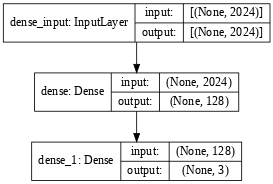

In [ ]:
utils.plot_model(model, dpi=60, show_shapes=True)

In [ ]:
history = model.fit(xTrain, zTrain,
                    batch_size=64, 
                    epochs=32,
                    validation_data=(xVal, zVal),
                    verbose=1)

Epoch 1/32
47/47 [==============================] - 1s 9ms/step - loss: 1.0329 - accuracy: 0.5193 - val_loss: 0.6697 - val_accuracy: 0.7711
Epoch 2/32
47/47 [==============================] - 0s 6ms/step - loss: 0.4680 - accuracy: 0.8793 - val_loss: 0.4215 - val_accuracy: 0.8789
Epoch 3/32
47/47 [==============================] - 0s 5ms/step - loss: 0.2904 - accuracy: 0.9357 - val_loss: 0.3072 - val_accuracy: 0.9078
Epoch 4/32
47/47 [==============================] - 0s 6ms/step - loss: 0.2016 - accuracy: 0.9657 - val_loss: 0.2412 - val_accuracy: 0.9333
Epoch 5/32
47/47 [==============================] - 0s 5ms/step - loss: 0.1474 - accuracy: 0.9840 - val_loss: 0.1964 - val_accuracy: 0.9467
Epoch 6/32
47/47 [==============================] - 0s 5ms/step - loss: 0.1114 - accuracy: 0.9910 - val_loss: 0.1642 - val_accuracy: 0.9533
Epoch 7/32
47/47 [==============================] - 0s 5ms/step - loss: 0.0871 - accuracy: 0.9950 - val_loss: 0.1398 - val_accuracy: 0.9633
Epoch 8/32
47/47 [==

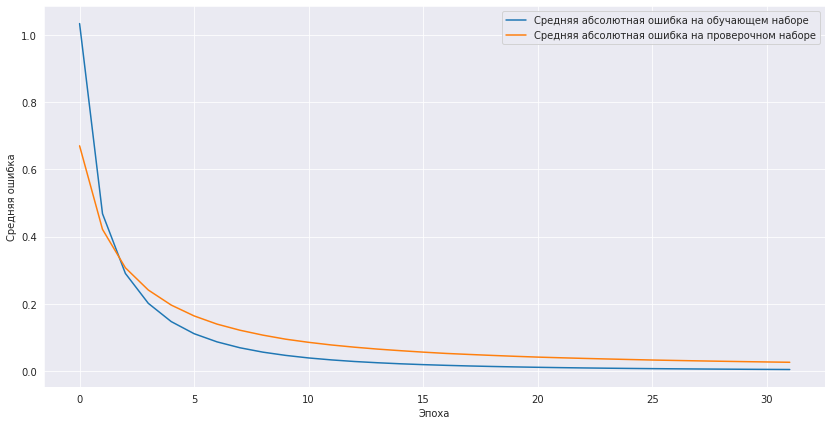

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

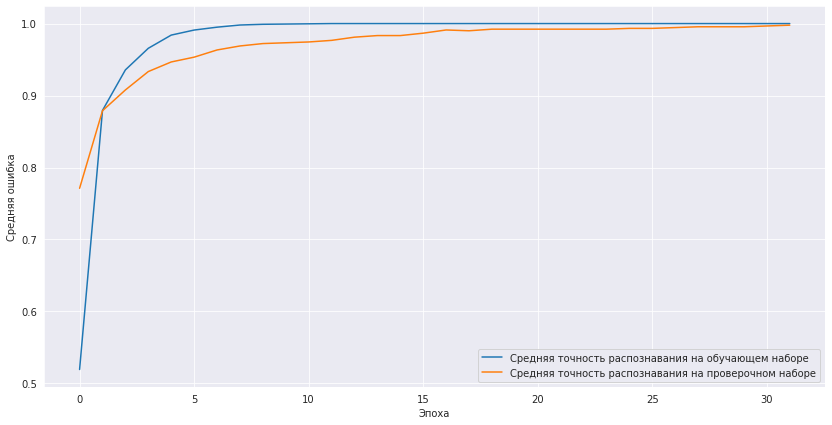

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'],
         label='Средняя точность распознавания на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Средняя точность распознавания на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

**Предсказание модели на тестовых данных**

In [ ]:
pred = model.predict(xTest)

**Оценка качества работы сети**

In [ ]:
scores = model.evaluate(xTest, zTest, verbose=1)
print(scores)
print('Доля верных ответов на тестовых данных, в процентах: ', round(scores[1] * 100, 4), '%', sep='')

10/10 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9967
[0.02027137577533722, 0.996666669845581]
Доля верных ответов на тестовых данных, в процентах: 99.6667%


**Обучение нейронной сети на спектре сигнала**

In [ ]:
model_sft = Sequential()
model_sft.add(Dense(128, activation='tanh', input_shape=(xTrain.shape[1],)))
model_sft.add(Dense(3, activation='softmax'))

model_sft.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history_sft = model_sft.fit(yTrain, zTrain,
                    batch_size=64, 
                    epochs=32,
                    validation_data=(yVal, zVal),
                    verbose=1)

Epoch 1/32
47/47 [==============================] - 1s 9ms/step - loss: 0.8162 - accuracy: 0.4533 - val_loss: 0.6971 - val_accuracy: 0.6222
Epoch 2/32
47/47 [==============================] - 0s 6ms/step - loss: 0.6385 - accuracy: 0.8173 - val_loss: 0.5721 - val_accuracy: 0.9144
Epoch 3/32
47/47 [==============================] - 0s 5ms/step - loss: 0.5320 - accuracy: 0.9277 - val_loss: 0.4834 - val_accuracy: 0.9267
Epoch 4/32
47/47 [==============================] - 0s 4ms/step - loss: 0.4525 - accuracy: 0.9337 - val_loss: 0.4154 - val_accuracy: 0.9289
Epoch 5/32
47/47 [==============================] - 0s 5ms/step - loss: 0.3889 - accuracy: 0.9370 - val_loss: 0.3618 - val_accuracy: 0.9344
Epoch 6/32
47/47 [==============================] - 0s 5ms/step - loss: 0.3379 - accuracy: 0.9427 - val_loss: 0.3169 - val_accuracy: 0.9389
Epoch 7/32
47/47 [==============================] - 0s 5ms/step - loss: 0.2959 - accuracy: 0.9513 - val_loss: 0.2796 - val_accuracy: 0.9467
Epoch 8/32
47/47 [==

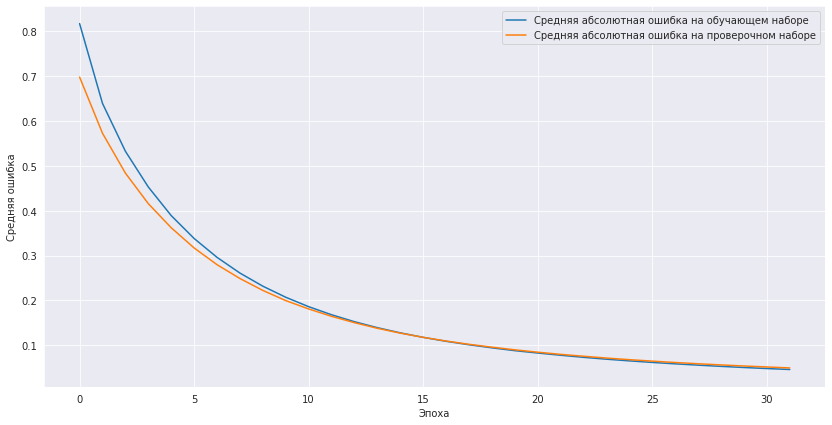

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_sft.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history_sft.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

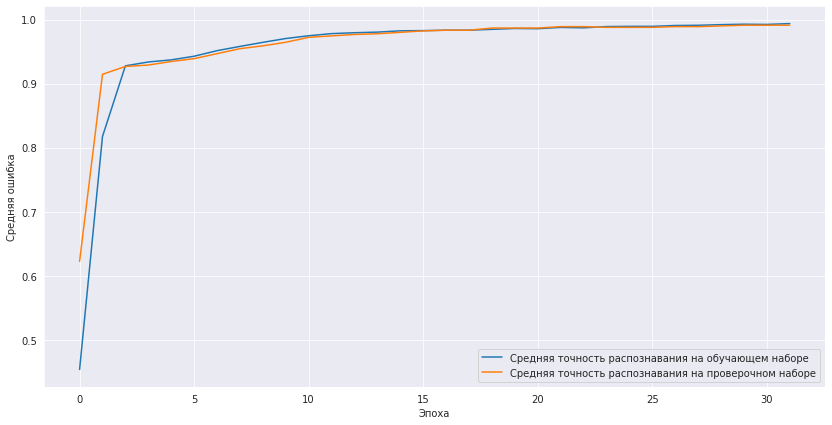

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_sft.history['accuracy'],
         label='Средняя точность распознавания на обучающем наборе')
plt.plot(history_sft.history['val_accuracy'],
         label='Средняя точность распознавания на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

**Предсказание модели на тестовых данных**

In [ ]:
pred_sft = model_sft.predict(yTest)

**Оценка качества работы сети**

In [ ]:
scores_sft = model_sft.evaluate(yTest, zTest, verbose=1)
print(scores_sft)
print('Доля верных ответов на тестовых данных, в процентах: ', round(scores_sft[1] * 100, 4), '%', sep='')

10/10 [==============================] - 0s 2ms/step - loss: 0.0495 - accuracy: 0.9900
[0.04953937232494354, 0.9900000095367432]
Доля верных ответов на тестовых данных, в процентах: 99.0%


**Функциональное программирование (API)**

Для примера создадим нейронную сеть в виде ветвей. 

На вход сети будем подавать одновременно реализацию и спектр сигнала. Чем больше данных поступает на вход нейронной сети, тем больше признаков сможет выделить данная сеть и вероятность повышения метрики станет выше.

In [ ]:
input_layer_1 = Input(shape=xTrain.shape[1])
input_layer_2 = Input(shape=yTrain.shape[1])

dense_1 = Dense(64, activation='tanh')(input_layer_1)
dense_2 = Dense(64, activation='tanh')(input_layer_2)

merge = concatenate([dense_1, dense_2])

output_layer = Dense(3, activation='softmax')(merge)

model_two = Model((input_layer_1, input_layer_2), output_layer)

model_two.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model_two.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2024)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2024)]       0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 64)           129600      input_3[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           129600      input_4[0][0]                    
____________________________________________________________________________________________

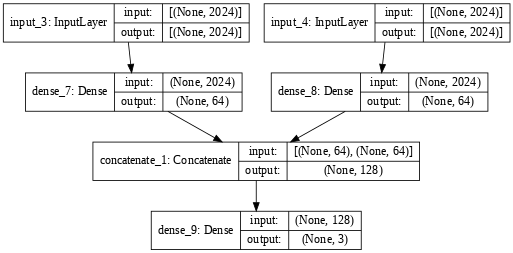

In [ ]:
utils.plot_model(model_two, dpi=60, show_shapes=True)

In [ ]:
history_two = model_two.fit([xTrain, yTrain], zTrain,
                    batch_size=64, 
                    epochs=32,
                    validation_data=([xVal, yVal], zVal),
                    verbose=1)

Epoch 1/32
47/47 [==============================] - 1s 9ms/step - loss: 0.8965 - accuracy: 0.5713 - val_loss: 0.6186 - val_accuracy: 0.7867
Epoch 2/32
47/47 [==============================] - 0s 7ms/step - loss: 0.4661 - accuracy: 0.8777 - val_loss: 0.3976 - val_accuracy: 0.9189
Epoch 3/32
47/47 [==============================] - 0s 6ms/step - loss: 0.3029 - accuracy: 0.9510 - val_loss: 0.2871 - val_accuracy: 0.9467
Epoch 4/32
47/47 [==============================] - 0s 6ms/step - loss: 0.2158 - accuracy: 0.9717 - val_loss: 0.2227 - val_accuracy: 0.9589
Epoch 5/32
47/47 [==============================] - 0s 6ms/step - loss: 0.1638 - accuracy: 0.9797 - val_loss: 0.1795 - val_accuracy: 0.9700
Epoch 6/32
47/47 [==============================] - 0s 6ms/step - loss: 0.1280 - accuracy: 0.9870 - val_loss: 0.1485 - val_accuracy: 0.9744
Epoch 7/32
47/47 [==============================] - 0s 7ms/step - loss: 0.1027 - accuracy: 0.9910 - val_loss: 0.1255 - val_accuracy: 0.9767
Epoch 8/32
47/47 [==

**Визуализация абсолютной ошибки**

**Обучающий набор (тренировочный набор)**

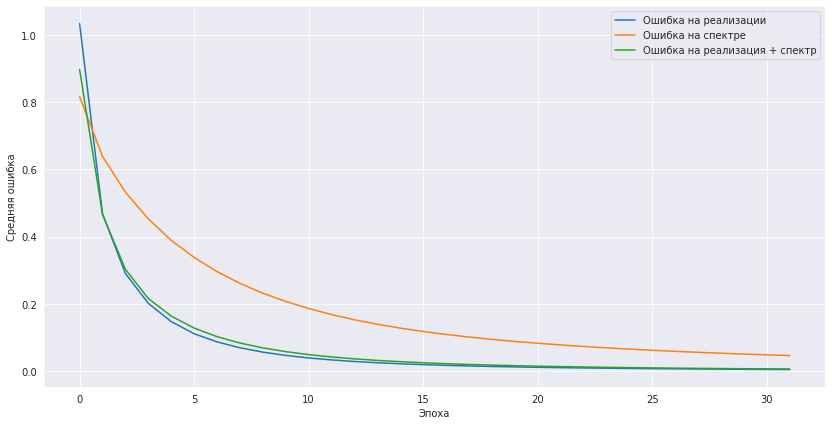

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'],
         label='Ошибка на реализации')
plt.plot(history_sft.history['loss'],
         label='Ошибка на спектре')
plt.plot(history_two.history['loss'],
         label='Ошибка на реализация + спектр')
plt.ylabel('Средняя ошибка')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

**Проверочный набор (валидационный набор)**

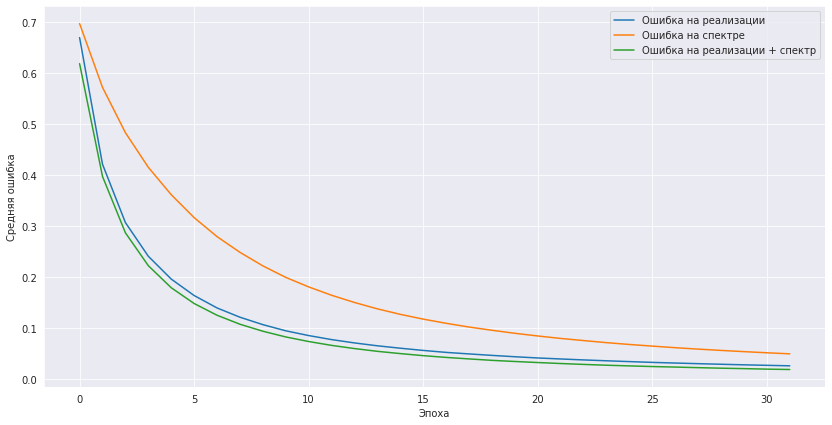

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['val_loss'],
         label='Ошибка на реализации')
plt.plot(history_sft.history['val_loss'],
         label='Ошибка на спектре')
plt.plot(history_two.history['val_loss'],
         label='Ошибка на реализации + спектр')
plt.ylabel('Средняя ошибка')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

**Визуализация точности**

**Обучающий набор (тренировочный набор)**

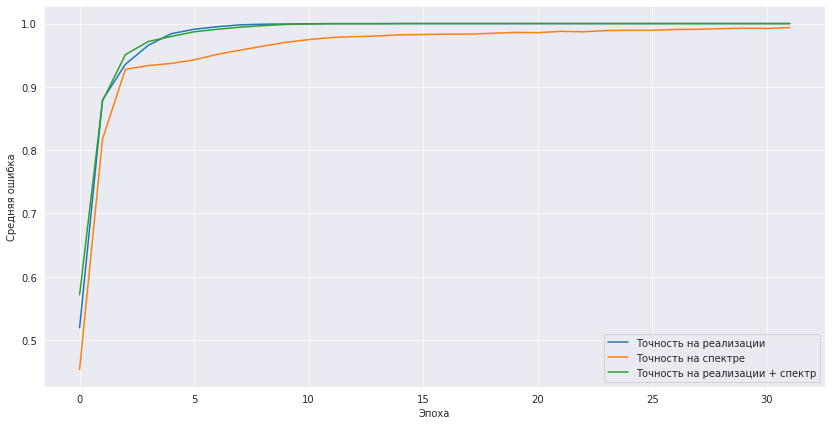

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'],
         label='Точность на реализации')
plt.plot(history_sft.history['accuracy'],
         label='Точность на спектре')
plt.plot(history_two.history['accuracy'],
         label='Точность на реализации + спектр')
plt.ylabel('Средняя ошибка')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

**Проверочный набор (валидационный набор)**

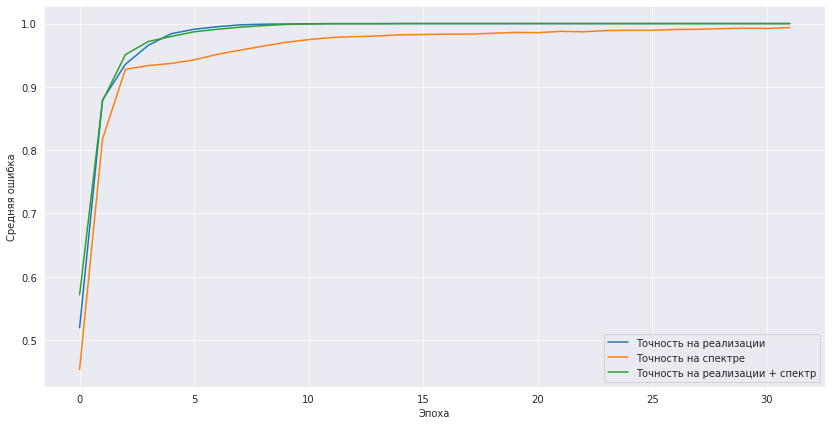

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'],
         label='Точность на реализации')
plt.plot(history_sft.history['accuracy'],
         label='Точность на спектре')
plt.plot(history_two.history['accuracy'],
         label='Точность на реализации + спектр')
plt.ylabel('Средняя ошибка')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

**Предсказание модели на тестовых данных**

In [ ]:
pred_two = model_two.predict([xTest, yTest])

**Оценка качества работы сети**

In [ ]:
scores_two = model_two.evaluate([xTest, yTest], zTest, verbose=1)
print(scores_two)
print('Доля верных ответов на тестовых данных, в процентах: ', round(scores_two[1] * 100, 4), '%', sep='')

10/10 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9967
[0.015299932099878788, 0.996666669845581]
Доля верных ответов на тестовых данных, в процентах: 99.6667%
